In [1]:
import pandas as pd
import numpy as npx
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
# from azureml.core import Workspace, Dataset
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import joblib

# pd.options.display.max_rows = None
# pd.options.display.max_columns = None

# subscription_id = 'e6d246af-433b-4498-91c7-019672b16c42'
# resource_group = 'rg-fundit-ml-dev'
# workspace_name = 'fundit-ml-ws1'

# workspace = Workspace(subscription_id, resource_group, workspace_name)
# Load the workspace from the configuration
# workspace = Workspace.from_config()

# # List datasets within the workspace
# datasets = Dataset.list(workspace)
# for dataset in datasets:
#     print(dataset.name)


In [2]:
# df = Dataset.get_by_name(workspace, name='latest_flat_loan')
df= pd.read_csv('FloanData.csv')
# Assuming df is your DataFrame just becuz either some of it is irrelevant or the channel and loantype only contain one category
columns_to_remove = ['LoanSystemSource', 'Channel','ID','ActualClosingDate', 'PurchasedByInvestorDt', 
'TotalPrice', 'FundingPckgReceiveDate', 'DisbursementDate', 'LoanNumber', 'bName','BranchID', 'ClearToCloseDate','ClosingReqDate',
'TotalLoanAmount', 'ModifiedTimestamp', 'SubmittedToInvestorDate','ConfirmedClosingDate',  'PlannedClosingDate',  'TotalPayment',
 'CompletionDate', 'NOIStartDate', 'DocInitialSentDate', 'DocDrawnDate']
#  df
# Remove specified columns
df = df.drop(columns=columns_to_remove)
df_cache = df.copy()
df.head(2)

C:\Users\timmy\AppData\Local\Temp\ipykernel_20344\552127883.py:2: DtypeWarning: Columns (126) have mixed types. Specify dtype option on import or set low_memory=False.
  df= pd.read_csv('FloanData.csv')


,Unnamed: 0,propertyCounty,APR,LoanTerm,HMDAActionTypeCode,Company,CashoutToBorrower,DocType,ServicingType,SuspenseStatus,...,WireRequestDate,ActualRescindedDate,DocOrderedDate,ClosingDetailFundingDate,LoanRescissionDate,ReadyforDocs,PackagedDate,FundingPckgReviewDate,SubmitToLender,FIT_LoanSubType
0,0,Cheshire,3.958,360,1 - Loan Originated,REG,19350.76,Full,Released,Assigned,...,NaN,NaN,2017-09-11,NaN,NaN,2017-09-08 08:55:00,2017-09-26,NaN,NaN,"Government Loans (FHA, VA)"
1,1,King,4.614,360,1 - Loan Originated,RPM,-53464.38,Full,Retained,Unassigned,...,2016-11-23 08:24:00,NaN,2016-11-18,2016-11-23T00:00:00+00:00,NaN,2016-11-18 11:35:00,2016-12-06,NaN,NaN,Agency conforming loans (FNMA & FHLMC)


In [3]:
df.nunique()

Unnamed: 0               107828
propertyCounty              894
APR                        5799
LoanTerm                     16
HMDAActionTypeCode            7
                          ...  
ReadyforDocs              81762
PackagedDate               1838
FundingPckgReviewDate       392
SubmitToLender                3
FIT_LoanSubType              10
Length: 105, dtype: int64

In [4]:
features = [
    'FundingDate',
    'DocSentDate',
    'InitialDisclosureDate',
    'ApplicationReceivedDate',
    'PropertyZip',
    'CashoutToBorrower',
    'DocOrderedDate',
    'propertyCounty',
    'CreateDate',
    'Points',
    'LockExpirationDate',
    'CostCenter',
    'APR',
    'ReadyforDocs',
    'AppraisalValue',
    'QualifyingHousingRatio',
    'Branch',
    'FICO',
    'PrimaryBorrowerZip',
    'DTI',
    'PropertyCity',
    'TotalMortgageLoanAmount',
    'CLTV',
    'PrimaryBorrowerCity',
    'SentToProcessingDate',
    'Investor',
    'Region',
    'InterestRate',
    'LoanPurpose',
    'LTV',
    'LockDate'
]

In [5]:
df = df[features]

In [6]:
df.values[0]

array(['2017-09-12', '2017-09-11 07:44:00', '2017-08-02', '2017-07-31',
       3447, 19350.76, '2017-09-11', 'Cheshire', '2017-06-10', -0.135,
       '2017-09-18', 83.0, 3.958, '2017-09-08 08:55:00', 300000.0, 17.825,
       'Keene II', 772, '03470', 26.9, 'Fitzwilliam', 300103.0, 97.0,
       'Richmond', '2017-08-04 08:59:00', 'RMC Wells Fargo', 'REG', 3.625,
       'Purchase', 97.0, '2017-08-04'], dtype=object)

In [7]:
df.shape

(107828, 31)

In [8]:
df.head(20)                                             

,FundingDate,DocSentDate,InitialDisclosureDate,ApplicationReceivedDate,PropertyZip,CashoutToBorrower,DocOrderedDate,propertyCounty,CreateDate,Points,...,TotalMortgageLoanAmount,CLTV,PrimaryBorrowerCity,SentToProcessingDate,Investor,Region,InterestRate,LoanPurpose,LTV,LockDate
0,2017-09-12,2017-09-11 07:44:00,2017-08-02,2017-07-31,3447,19350.76,2017-09-11,Cheshire,2017-06-10,-0.135,...,300103.0,97.000,Richmond,2017-08-04 08:59:00,RMC Wells Fargo,REG,3.625,Purchase,97.000,2017-08-04
1,2016-11-23,2016-11-18 12:44:00,2016-10-27,2016-10-24,98074,-53464.38,2016-11-18,King,2016-10-23,0.308,...,186000.0,75.000,Sammamish,2016-10-27 11:55:00,RPM Fannie Mae,PNW-WA,4.500,Cash-Out Refi,75.000,2016-11-01
2,2022-03-03,2022-02-28 13:00:00,2022-02-14,2022-02-10,91403,1107254.66,2022-02-25,Los Angeles,2022-01-19,0.668,...,850000.0,42.714,Santa Monica,2022-02-14 17:25:00,RPM Wells Fargo,SOCAL,4.375,Purchase,42.714,2022-02-10
3,2016-12-12,2016-12-07 10:05:00,2016-10-28,2016-10-27,93108,-289.18,2016-12-06,Santa Barbara,2016-10-26,0.125,...,1059000.0,62.294,PASADENA,2016-11-21 15:39:00,Chase First,NORCAL,3.375,No Cash-Out Refi,62.294,2016-10-27
4,2021-12-07,2021-12-05 14:07:00,2021-11-16,2021-11-10,95688,-490.39,2021-12-02,Solano,2021-09-28,-0.121,...,631200.0,80.000,Danville,2021-11-18 15:57:00,Pentagon Federal Credit Union,NORCAL,3.250,Purchase,80.000,2021-11-10
5,2016-12-15,2016-12-05 09:25:00,2016-10-25,2016-10-21,94542,481610.37,2016-12-02,Alameda,2016-10-12,-0.088,...,780000.0,60.938,San Jose,2016-11-07 11:01:00,Wells Fargo,NORCAL,3.625,Purchase,60.938,2016-10-21
6,NaN,NaN,2022-02-25,2022-02-22,90048,-575873.36,NaN,Los Angeles,2022-01-18,0.000,...,1020000.0,52.308,Los Angeels,2022-03-21 11:20:00,Onslow Bay Financial LLC,NORCAL,5.125,Cash-Out Refi,52.308,NaN
7,NaN,NaN,2019-08-14,2019-08-09,30184,-60708.80,NaN,Cobb,2019-08-08,-1.795,...,65000.0,58.337,White,NaN,PennyMac,KEGA,5.000,Cash-Out Refi,36.111,NaN
8,2018-12-21,2018-12-21 12:08:00,2018-12-03,2018-11-30,29316,7068.15,2018-12-21,Spartanburg,2018-11-09,0.263,...,186459.0,100.000,Piedmont,2018-12-05 12:21:00,CBC Mortgage Agency,SC,5.500,Purchase,96.500,2018-12-04
9,2020-12-09,2020-12-01 08:13:00,2020-11-17,2020-11-12,85310,42.12,2020-11-24,Maricopa,2020-11-12,0.102,...,266250.0,85.887,Glendale,2020-11-18 14:28:00,RPM Freedom Mtg,SOCAL,2.250,No Cash-Out Refi,85.887,2020-11-12


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107828 entries, 0 to 107827
Data columns (total 31 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   FundingDate              86003 non-null   object 
 1   DocSentDate              86324 non-null   object 
 2   InitialDisclosureDate    107828 non-null  object 
 3   ApplicationReceivedDate  107805 non-null  object 
 4   PropertyZip              107828 non-null  int64  
 5   CashoutToBorrower        107828 non-null  float64
 6   DocOrderedDate           86441 non-null   object 
 7   propertyCounty           107824 non-null  object 
 8   CreateDate               107828 non-null  object 
 9   Points                   107824 non-null  float64
 10  LockExpirationDate       97573 non-null   object 
 11  CostCenter               107175 non-null  float64
 12  APR                      107828 non-null  float64
 13  ReadyforDocs             86494 non-null   object 
 14  Appr

In [10]:
# Preprocessing 1 -------------------------------------------------
df= df.dropna(subset=['FundingDate'])
df['FundingDate'] = pd.to_datetime(df['FundingDate'])
df['InitialDisclosureDate'] = pd.to_datetime(df['InitialDisclosureDate'])
# # Calculate the difference in days
df['Days_Fund'] = (df['FundingDate'] - df['InitialDisclosureDate']).dt.days
# df = df.drop(columns=['FundingDate'])

df_funded = df.copy()
# Filter rows where Days_Fund_Investor is greater than 1 and less than 70
df_funded = df_funded[(df_funded['Days_Fund'] > 9) & (df_funded['Days_Fund'] < 91)]

# Calculate the percentage of missing data for each column
missing_percentages = df_funded.isnull().mean() * 100
# Identify columns where the percentage of missing data is greater than 20%
columns_to_drop = missing_percentages[missing_percentages > 20].index.tolist()
# Keep a record of these columns
removed_columns_record = columns_to_drop.copy()
# Drop these columns from the DataFrame
df_funded = df_funded.drop(columns=columns_to_drop)

# Convert the 'propertyZip' column to numerical values
df_funded['PropertyZip'] = pd.to_numeric(df_funded['PropertyZip'], errors='coerce')

# Remove '-' and characters after it from the 'PrimaryBorrowerZip' column
df_funded['PrimaryBorrowerZip'] = df_funded['PrimaryBorrowerZip'].str.replace(r'-.*', '')
# Convert the 'PrimaryBorrowerZip' column to numerical values
df_funded['PrimaryBorrowerZip'] = pd.to_numeric(df_funded['PrimaryBorrowerZip'], errors='coerce')

numerical = []
categorical = []

datetime_columns = [col for col in df.columns if 'Date' in col]
datetime_columns.append('ReadyforDocs')


# Iterate through the datatime column and comvert to oandas to_datetime
for column in datetime_columns:
    df_funded[column] = pd.to_datetime(df_funded[column])
# get the minimum date for each column and save for each column in a dictionary
min_dates = df_funded[datetime_columns].min()

# Iterate through datetime columns and convert to days
for column in datetime_columns:
    df_funded[column] = (df_funded[column] - df_funded[column].min()).dt.days


# Loop through columns
for column in df_funded.columns:
    if column != 'Days_Fund':
        if df_funded[column].dtype in ['int64', 'float64']:
            numerical.append(column)
        elif pd.api.types.is_datetime64_any_dtype(df_funded[column]):
            datetime_columns.append(column)
        else:
            categorical.append(column)

# Filling nan for the categorical variable with mode
for col in categorical:
      df_funded[col].fillna(df_funded[col].mode()[0], inplace=True)

# Impute missing numerical data with mean, median, or mode
for col in numerical:
    if df_funded[col].dtype == 'float64' or df_funded[col].dtype == 'int64':
        # Impute with mean
        df_funded[col].fillna(df_funded[col].mean(), inplace=True)


# Perform backward fill for remaining missing values
df_funded = df_funded.bfill()

def handle_outliers(df, column):
 
    # Calculate IQR
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Define limits
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Find outliers
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

    # Remove outliers
    df_clean = df[~df.index.isin(outliers.index)]
    
    return df_clean

# Replace 'target' with your actual target column name
df_clean = handle_outliers(df_funded, 'Days_Fund')

# Create the feature matrix X
X = df_clean[features[1:]]
# X = df_clean.drop(columns=['Days_Fund'])
y = df_clean['Days_Fund']

In [14]:
X['APR'].head()

0    3.958
1    4.614
2    4.461
3    3.690
4    3.314
Name: APR, dtype: float64

In [15]:
datetime_columns

['FundingDate',
 'DocSentDate',
 'InitialDisclosureDate',
 'ApplicationReceivedDate',
 'DocOrderedDate',
 'CreateDate',
 'LockExpirationDate',
 'SentToProcessingDate',
 'LockDate',
 'ReadyforDocs']

In [87]:
minimum_dates = {
   "FundingDate": "2016-05-11 00:00:00",
   "DocSentDate": "2016-05-05 10:24:00",
   "InitialDisclosureDate": "2016-04-06 00:00:00",
   "ApplicationReceivedDate": "2016-04-05 00:00:00",
   "DocOrderedDate": "2016-05-05 00:00:00",
   "CreateDate": "2016-03-07 00:00:00",
   "LockExpirationDate": "2016-05-16 00:00:00",
   "SentToProcessingDate": "2016-04-12 16:35:00",
   "LockDate": "2016-04-05 00:00:00",
   "ReadyforDocs": "2016-04-29 14:13:00"
}

FundingDate               2016-05-11 00:00:00
DocSentDate               2016-05-05 10:24:00
InitialDisclosureDate     2016-04-06 00:00:00
ApplicationReceivedDate   2016-04-05 00:00:00
DocOrderedDate            2016-05-05 00:00:00
CreateDate                2016-03-07 00:00:00
LockExpirationDate        2016-05-16 00:00:00
SentToProcessingDate      2016-04-12 16:35:00
LockDate                  2016-04-05 00:00:00
ReadyforDocs              2016-04-29 14:13:00
dtype: datetime64[ns]

In [74]:
numerical = [col for col in X.columns if X[col].dtype in ['int64', 'float64']]
categorical = [col for col in X.columns if X[col].dtype == 'object']

In [75]:
X.shape

(79342, 30)

In [76]:
numerical_transformer = SimpleImputer(strategy='mean')  # For numerical imputation
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # For categorical imputation
    ('encoder', OrdinalEncoder())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical),
        ('cat', categorical_transformer, categorical)
    ]
)

# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),  # Scale numerical columns after imputation
])




In [77]:
X = pipeline.fit_transform(X)

In [88]:
# save the pipeline
joblib.dump(pipeline, 'preprocessor.pkl')

['preprocessor.pkl']

In [78]:
# Fit and transform the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [79]:
X_train

array([[ 0.47165193,  0.47399093,  0.47383958, ...,  1.26996415,
        -1.03602748,  0.70601661],
       [-1.72766288, -1.68913966, -1.68843367, ...,  1.45677753,
         1.27235911,  0.70601661],
       [-1.09465606, -1.07841351, -1.07746775, ..., -1.27749095,
         0.31053136, -1.89284687],
       ...,
       [ 1.31111111,  1.32013665,  1.32373072, ...,  1.45677753,
        -0.26656528,  0.70601661],
       [-1.23968458, -1.21488863, -1.21740966, ...,  0.64159189,
        -1.22839303, -1.02655904],
       [ 0.38122238,  0.40916525,  0.41240167, ..., -1.61715163,
        -1.80548968,  0.70601661]])

In [80]:
X_train.shape

(63473, 30)

## Modelling

In [81]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score  # Import r2_score

# Create an XGBRegressor for regression
xgb_regressor = XGBRegressor(random_state=42)

# Train the model
xgb_regressor.fit(X_train, y_train)

# Predict the days using the trained model
y_pred = xgb_regressor.predict(X_test)

# Compute Mean Absolute Error (MAE), Mean Squared Error (MSE), and R-squared
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r_squared}')


# Create a DataFrame with actual and predicted values
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Display the first few rows of the results DataFrame
print(results_df.head(10))

Mean Absolute Error: 5.029259766077407
Mean Squared Error: 43.49238921516335
R-squared: 0.6781843041809671
        Actual  Predicted
51440       29  37.103882
43392       32  39.406994
8711        18  27.677155
46189       22  24.120781
5539        39  37.634167
79368       39  35.481625
74053       46  40.651611
57206       19  24.294176
99106       15  20.654652
103126      39  32.394947


In [90]:
# save the model
joblib.dump(xgb_regressor, 'base_model.pkl')

['base_model.pkl']

In [89]:
results_df.tail(30)

,Actual,Predicted
51964,40,44.948292
32754,24,17.081993
95266,49,44.024040
106963,15,25.935211
76140,15,26.009624
47065,34,28.177498
75664,25,28.429560
51432,64,51.593189
102076,31,28.740461
14756,37,33.951984


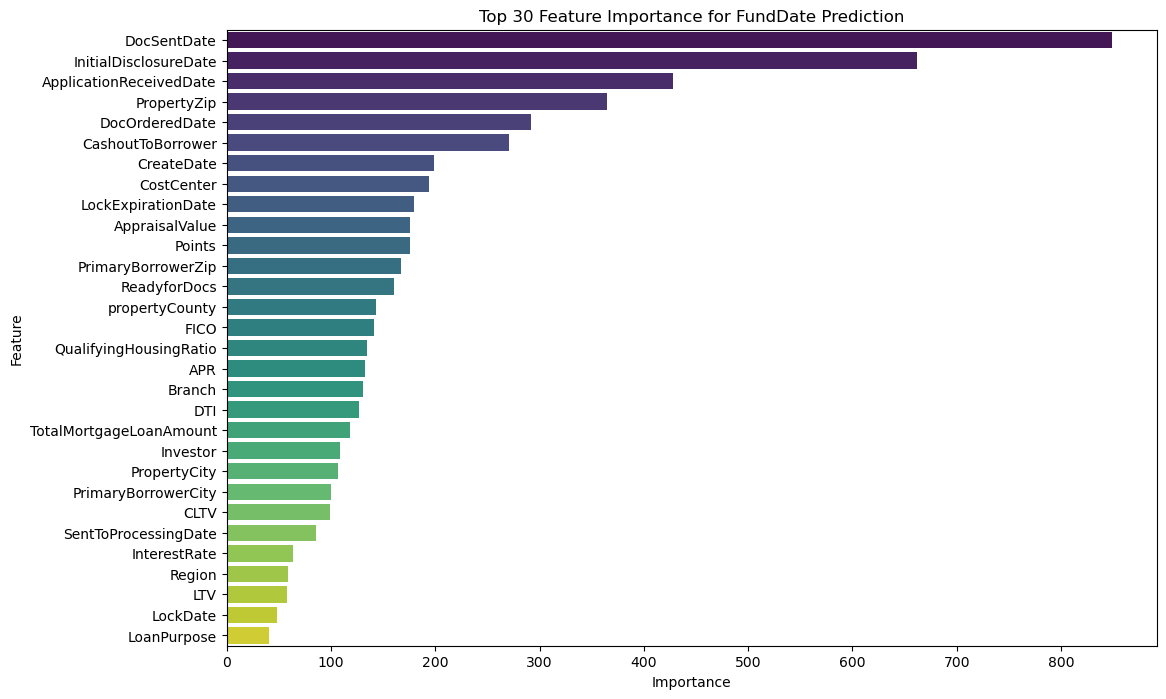

In [9]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
import xgboost as xgb

# Create XGBoost DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)

# Set hyperparameters for XGBoost
params = {
    'objective': 'reg:squarederror',  # for regression tasks
    'eval_metric': 'rmse'  # use root mean squared error for evaluation
}

# Train XGBoost model
model = xgb.train(params, dtrain, num_boost_round=100)

# Get feature importance
importance_dict = model.get_fscore()
# Convert the dictionary to a DataFrame for easier manipulation
feature_importance_df = pd.DataFrame(list(importance_dict.items()), columns=['Feature', 'Importance'])
# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Select the top 30 features
top_30_features = feature_importance_df.head(30)

# Plot the top 30 features
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=top_30_features, palette='viridis')
plt.title('Top 30 Feature Importance for FundDate Prediction')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [13]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((63473, 30), (15869, 30), (63473,), (15869,))

## Hyperparameter Tuning

In [43]:
import optuna
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
X_train.head(15)

,DocSentDate,InitialDisclosureDate,ApplicationReceivedDate,PropertyZip,CashoutToBorrower,DocOrderedDate,propertyCounty,CreateDate,Points,LockExpirationDate,CostCenter,APR,ReadyforDocs,AppraisalValue,QualifyingHousingRatio,Branch,FICO,PrimaryBorrowerZip,DTI,PropertyCity,TotalMortgageLoanAmount,CLTV,PrimaryBorrowerCity,SentToProcessingDate,Investor,Region,InterestRate,LoanPurpose,LTV,LockDate
57452,46705,0.473991,1392,-0.970231,-0.192313,1208,160,1418,3.049828,1013,1.067567,1.759491,46381,-0.743433,0.597011,79,-1.840879,-0.982090,0.866046,1619,-0.676378,0.935992,1015,46484,190,6,1.107753,3,0.951961,1050
59335,3187,-1.689140,178,0.883725,0.248924,135,662,196,-3.809949,128,-0.394963,0.808635,3255,-0.331523,-0.999675,157,0.608891,0.879616,-0.029476,3511,-0.478379,-0.169778,4251,3490,201,18,1.242746,3,-0.075664,138
40321,15528,-1.078414,524,0.673392,-0.701455,437,468,551,-0.359295,373,-1.623729,0.205087,15619,-0.231545,-0.131012,163,0.194845,0.668497,0.519084,3064,-0.092853,0.087378,3732,16377,37,13,0.567783,0,0.163318,387
83725,66660,1.019891,1710,-0.973407,-0.441362,1538,228,1773,0.822566,1240,1.067567,-0.005619,65670,-0.755631,-1.423538,79,0.212097,-0.978434,0.817591,2180,-0.855524,-0.475227,1246,65470,109,6,0.161726,0,-0.359528,1277
10146,34601,-0.106028,1063,-0.837170,-0.278893,912,573,1104,-0.423372,763,0.713923,1.683601,34358,-0.607463,1.077012,176,-0.495231,-0.871166,0.114094,1601,-0.467356,1.116001,4222,34681,26,20,1.107753,3,0.951961,796
55789,15671,-1.104003,509,-0.873813,-0.142022,440,569,524,0.353856,373,0.677959,0.792564,15514,-0.915396,-0.471133,111,-1.237063,-0.833402,0.464048,997,-1.044096,-0.169778,3486,15147,6,19,0.972761,3,-0.075664,376
72852,76364,1.453200,1950,0.971514,-0.290592,1754,673,2032,-0.410319,1414,0.006633,-0.713628,75339,1.848000,-0.432722,1,0.022326,-0.001545,0.147594,2489,0.979914,-1.710089,3011,75712,176,10,-0.512156,1,-1.507122,1434
94447,62692,0.936300,1658,0.955514,-0.212081,1464,11,1727,-0.977517,1188,0.000639,-1.056472,61722,2.367886,-0.437956,1,0.833166,0.950708,-0.938758,49,1.291687,-1.782041,64,62472,109,10,-0.917134,1,-1.573989,1220
17430,37564,0.049212,1150,-0.969991,-0.196492,978,160,1135,1.306702,826,1.067567,1.088981,37253,-0.811418,0.112957,79,-1.720116,-0.987605,-0.000762,1874,-0.791587,0.935992,1840,37721,109,6,0.297798,3,0.951961,860
50207,68173,1.118836,1767,-0.851132,-0.194153,1571,467,1788,-1.263490,1280,0.815820,0.301512,67267,-0.481491,0.964905,19,0.401868,-0.856300,-0.004352,430,-0.245166,0.935992,516,67763,10,20,-0.377164,3,0.951961,1318


In [45]:
# def objective(trial, X_train=X_train, y_train=y_train):
#     data, target = X_train, y_train
#     X_train, X_valid, y_train, y_valid = train_test_split(data, target, test_size=0.2, random_state=42)

#     param = {
#         'objective': 'reg:squarederror',
#         'eval_metric': 'rmse',
#         'booster': 'gbtree',
#         'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
#         'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
#         'gamma': trial.suggest_float('gamma', 0.0, 5.0),
#         'max_depth': trial.suggest_int('max_depth', 1, 10),
#         'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-8, 1.0),
#         # 'max_delta_step': trial.suggest_float('max_delta_step', 0.0, 10.0),
#         # 'subsample': trial.suggest_float('subsample', 0.1, 1.0),
#         # 'sampling_method': trial.suggest_categorical('sampling_method', ['uniform', 'gradient_based']),
#         # 'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.1, 1.0),
#         # 'colsample_bynode': trial.suggest_float('colsample_bynode', 0.1, 1.0),
#         # 'eta': trial.suggest_float('eta', 1e-8, 1.0),
#         # 'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.1, 10.0),
#         # 'refresh_leaf': trial.suggest_int('refresh_leaf', 0, 1),
#         # 'process_type': trial.suggest_categorical('process_type', ['default', 'update']),
#         # 'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
#         # 'max_leaves': trial.suggest_int('max_leaves', 0, 100),
    
#     }

#     model = xgb.train(param, xgb.DMatrix(X_train, label=y_train),
#                       evals=[(xgb.DMatrix(X_valid, label=y_valid), 'eval')],
#                       early_stopping_rounds=10,
#                       verbose_eval=False)

#     preds = model.predict(xgb.DMatrix(X_valid))
#     rmse = mean_squared_error(y_valid, preds, squared=False)
#     return rmse

# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=500)

# print('Best trial:')
# trial = study.best_trial
# print('Value: {}'.format(trial.value))
# print('Params: ')
# for key, value in trial.params.items():
#     print('{}: {}'.format(key, value))

[I 2023-12-24 17:26:27,578] A new study created in memory with name: no-name-4c9d2d86-5c07-47c5-a1cb-1b522a3ec9e5
C:\Users\timmy\AppData\Local\Temp\ipykernel_13892\3446855347.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
C:\Users\timmy\AppData\Local\Temp\ipykernel_13892\3446855347.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
C:\Users\timmy\AppData\Local\Temp\ipykernel_13892\3446855347.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3

Best trial:
Value: 9.114792706514008
Params: 
lambda: 0.02420983645585827
alpha: 8.933588079294868e-06
colsample_bytree: 0.8529007427907748
gamma: 4.939329148783582
max_depth: 10
min_child_weight: 0.09711558020004056


In [46]:
trial.params

{'lambda': 0.02420983645585827,
 'alpha': 8.933588079294868e-06,
 'colsample_bytree': 0.8529007427907748,
 'gamma': 4.939329148783582,
 'max_depth': 10,
 'min_child_weight': 0.09711558020004056}

In [47]:

params_1 = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'booster': 'gbtree',
    'lambda': 0.02420983645585827,
 'alpha': 8.933588079294868e-06,
 'colsample_bytree': 0.8529007427907748,
 'gamma': 4.939329148783582,
 'max_depth': 10,
 'min_child_weight': 0.09711558020004056
}

xgb_regressor = XGBRegressor(**params_1, random_state=42)

# Train the model
xgb_regressor.fit(X_train, y_train)

# Predict the days using the trained model
y_pred = xgb_regressor.predict(X_test)

# Compute Mean Absolute Error (MAE), Mean Squared Error (MSE), and R-squared
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r_squared}')


# Create a DataFrame with actual and predicted values
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Display the first few rows of the results DataFrame
print(results_df.head(10))

Mean Absolute Error: 4.697005624927069
Mean Squared Error: 38.703651256683074
R-squared: 0.7136178838488795
        Actual  Predicted
51440       29  34.234222
43392       32  36.227921
8711        18  25.719753
46189       22  27.805346
5539        39  38.584969
79368       39  34.025009
74053       46  44.718708
57206       19  20.592773
99106       15  24.073196
103126      39  35.078671


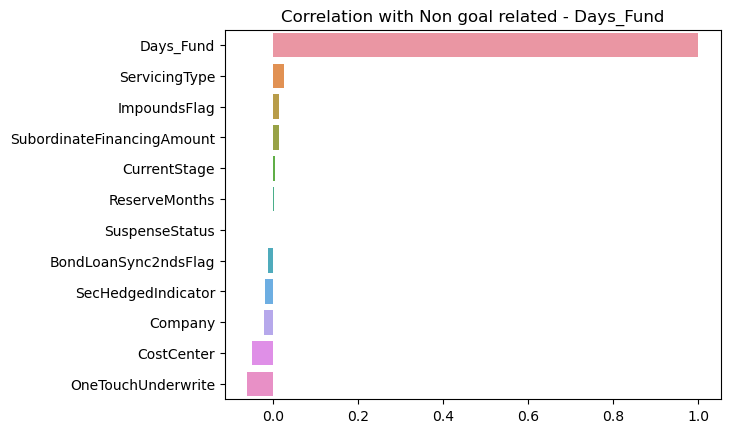

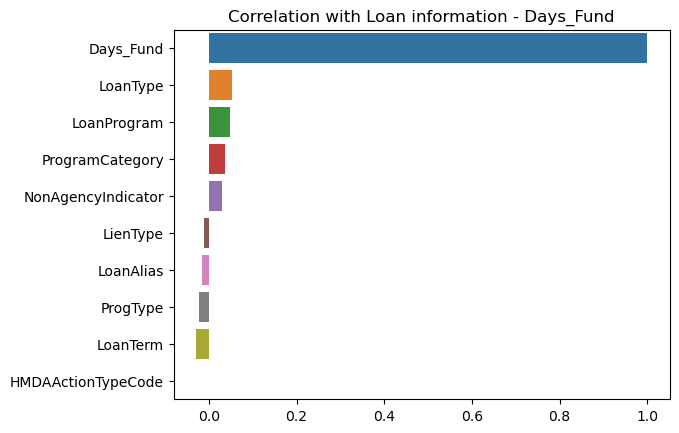

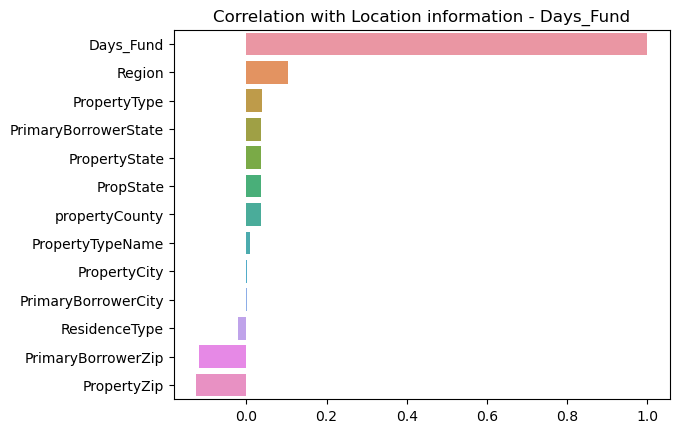

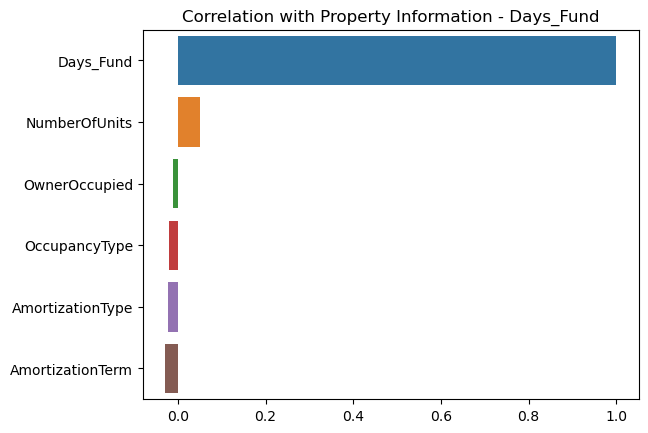

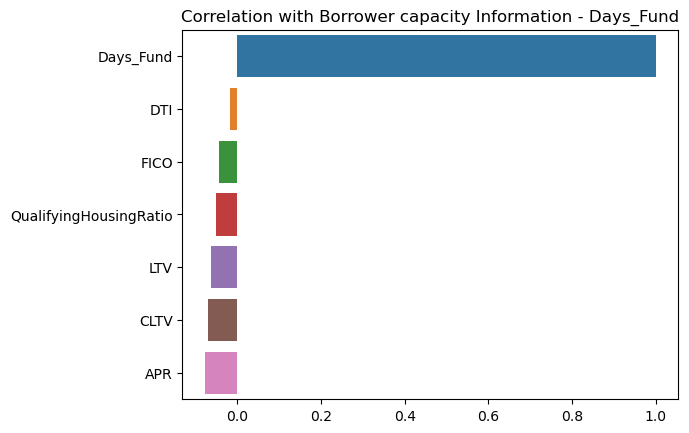

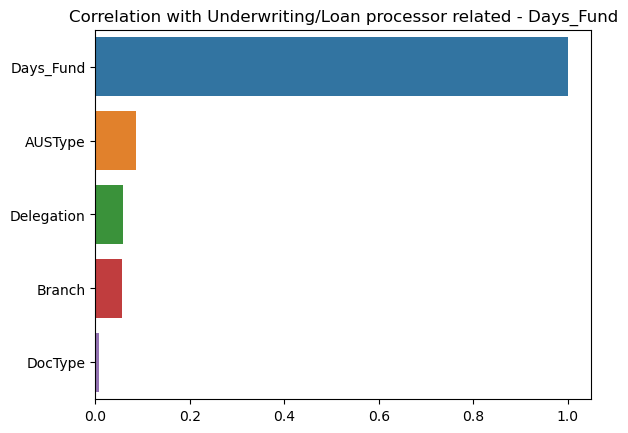

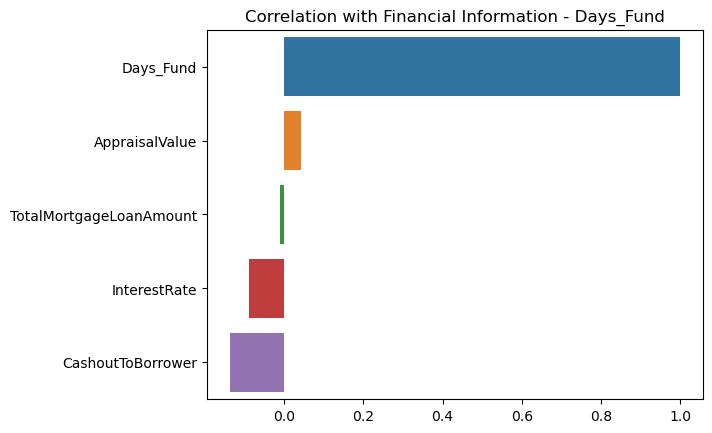

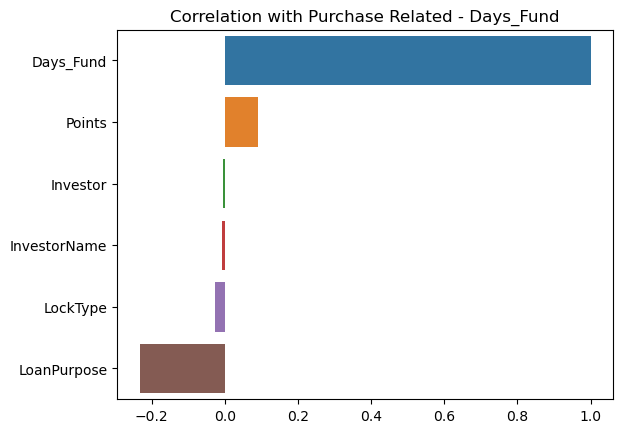

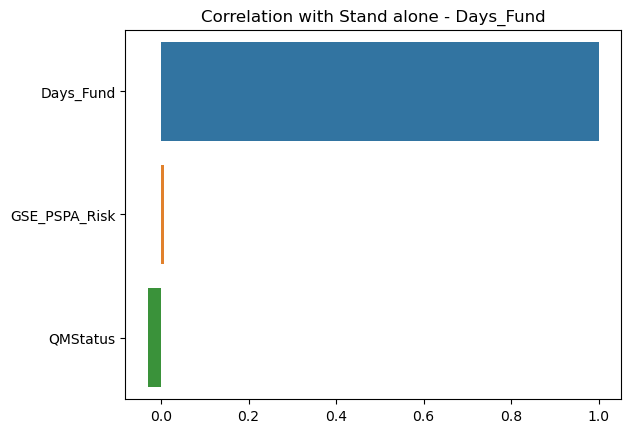

In [10]:
# Manually extracted column names from the image provided
feature_categories = {
    'Non goal related': ['CurrentStage', 'LoanSystemSource', 'BranchID', 'Channel', 'Company', 'bName', 'CostCenter', 'ServicingType', 'ImpoundsFlag', 'SuspenseStatus', 'OneTouchUnderwrite', 'SecHedgedIndicator', 'ReserveMonths', 'BondLoanSync2ndsFlag', 'SubordinateFinancingAmount'],
    'Loan information': ['LoanNumber', 'HMDAActionTypeCode', 'LoanAlias', 'LoanProgram', 'LoanType', 'LoanTerm', 'LienType', 'ProgramCategory', 'ProgType', 'NonAgencyIndicator'],
    'Location information': ['Region', 'propertyCounty', 'PropertyCity', 'PropertyZip', 'PropertyType', 'PropertyState', 'PropertyTypeName', 'PrimaryBorrowerZip', 'PropState', 'PrimaryBorrowerState', 'PrimaryBorrowerCity', 'ResidenceType'],
    'Property Information': ['OccupancyType', 'AmortizationType', 'AmortizationTerm', 'NumberOfUnits', 'OwnerOccupied'],
    'Borrower capacity Information': ['CLTV', 'LTV', 'FICO', 'DTI', 'APR', 'QualifyingHousingRatio'],
    'Underwriting/Loan processor related': ['DocType', 'AUSType', 'Branch', 'Delegation'],
    'Financial Information': ['TotalMortgageLoanAmount', 'TotalLoanAmount', 'InterestRate', 'AppraisalValue', 'TotalPayment', 'CashoutToBorrower'],
    'Purchase Related': ['Investor', 'InvestorName', 'LockType', 'Points', 'TotalPrice', 'LoanPurpose'],
    'Stand alone': ['QMStatus', 'GSE_PSPA_Risk']
}

# Function to calculate and plot correlation
def plot_correlation(df, features, target, title):
    available_features = [feature for feature in features if feature in df.columns]
    if available_features:
        corr_values = df[available_features + [target]].corr()[target].sort_values(ascending=False)
        sns.barplot(x=corr_values.values, y=corr_values.index)
        plt.title(f'Correlation with {title}')
        plt.show()
    else:
        missing = set(features) - set(df.columns)
        print(f'The following features are missing from the dataframe: {missing}')

# Replace 'Days_difference' and 'Days_Fund_Investor' with your actual column names
for category, features in feature_categories.items():
    plot_correlation(df_funded, features, 'Days_Fund', f'{category} - Days_Fund')
    # plot_correlation(df_funded, features, 'Days_Fund_Investor', f'{category} - Days_Fund_Investor')


In [11]:
# Assuming df is your DataFrame
# Replace 'YourDataFrame' with your actual DataFrame name

# Define the list of features
features = [
    'DocSentDate',
    'InitialDisclosureDate',
    'ApplicationReceivedDate',
    'PropertyZip',
    'CashoutToBorrower',
    'DocOrderedDate',
    'propertyCounty',
    'CreateDate',
    'Points',
    'LockExpirationDate',
    'CostCenter',
    'APR',
    'ReadyforDocs',
    'AppraisalValue',
    'QualifyingHousingRatio',
    'Branch',
    'FICO',
    'PrimaryBorrowerZip',
    'DTI',
    'PropertyCity',
    'TotalMortgageLoanAmount',
    'CLTV',
    'PrimaryBorrowerCity',
    'SentToProcessingDate',
    'Investor',
    'Region',
    'InterestRate',
    'LoanPurpose',
    'LTV',
    'LockDate'
]

# Define the list of selected columns
selected_columns = ['propertyCounty', 'HMDAActionTypeCode', 'Company', 'bName', 'DocType',
                     'ServicingType', 'SuspenseStatus', 'Delegation', 'QMStatus',
                     'NonAgencyIndicator', 'LoanPurpose', 'Region', 'OccupancyType',
                     'ProgramCategory', 'SecHedgedIndicator',
                     'AmortizationType', 'LoanType', 'PropertyZip', 'LienType',
                     'Branch', 'Investor', 'AUSType', 'CostCenter', 'LoanAlias',
                     'PropertyType', 'Milestone', 'PropertyState', 'GSE_PSPA_Risk',
                     'BondLoanSync2ndsFlag', 'LockType', 'PropertyTypeName',
                      'PropState', 'LoanProgram',
                     'PrimaryBorrowerState', 'InvestorName', 'ResidenceType',
                     'PrimaryBorrowerCity', 'ProgType', 'ImpoundsFlag', 'CurrentStage',
                     'OwnerOccupied', 'FIT_LoanSubType']

# Find common columns between features and selected_columns
common_columns = list(set(features) & set(selected_columns))

# Extract unique values for the common columns
unique_values_dict = {column: df[column].unique().tolist() for column in common_columns}

# Print or use the dictionary as needed
print(unique_values_dict)

# Save the dictionary to a text file
output_file_path = 'unique_values_for_top_columns_for_Funding.txt'
with open(output_file_path, 'w') as file:
    for column, values in unique_values_dict.items():
        file.write(f"{column}: {values}\n")

print(f"Unique values saved to {output_file_path}")

{'Investor': ['RMC Wells Fargo', 'RPM Fannie Mae', 'RPM Wells Fargo', 'Chase First', 'Pentagon Federal Credit Union', 'Wells Fargo', 'CBC Mortgage Agency', 'RPM Freedom Mtg', 'Pacific Union Financial', 'RPM Pennymac', 'NewRez, LLC', 'RMC Santander Bank, NA', 'Flagstar Bank, FSB', 'U.S. Bank HFA', 'BB& T Mortgage', 'LendUS GNMA', 'Pennymac', 'RMC Pennymac', 'AmeriHome', 'Chase Direct', 'RPM AmeriHome', 'RPM Chase', 'SG Capital Partners, LLC', 'SC Housing', 'JP Morgan Chase Bank, N.A.', 'Chase Fast Path', 'Wells Fargo Bank, N.A.', 'Flagstar', 'RPM BB&T Mortgage', 'Freedom Mortgage', 'Fifth Third Bank', 'Plaza Home Mortgage', 'RPM Caliber Home Loans', 'RPM HF5', 'Maxex JP Morgan', 'RPM Freddie Mac', 'RMC Chase First', 'Texas State Affordable House Corp', 'AEM Plaza Home Mortgage', 'BB& T Mortgage, now Truist Bank', 'RPM Nationstar Mortgage LLC d/b/a Mr. Cooper', 'Home Point Financial', 'RPM HF7', 'Planet Home Lending', 'AEM Georgia Housing and Finance Authority', 'Caliber Home Loans', 'Ge

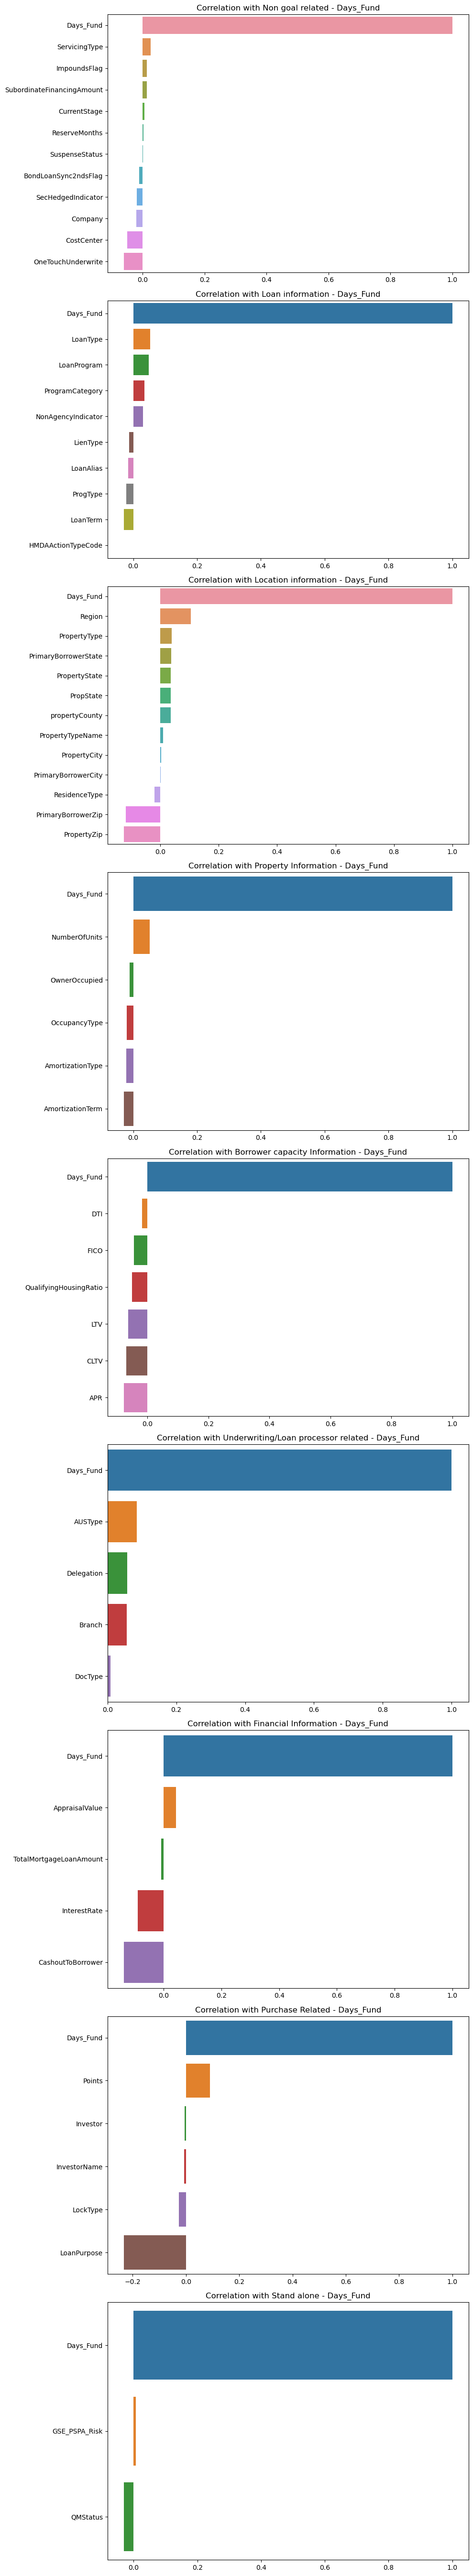

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df_funded is your DataFrame
# Replace df_funded with your actual DataFrame name

# Manually extracted column names from the image provided
feature_categories = {
    'Non goal related': ['CurrentStage', 'LoanSystemSource', 'BranchID', 'Channel', 'Company', 'bName', 'CostCenter', 'ServicingType', 'ImpoundsFlag', 'SuspenseStatus', 'OneTouchUnderwrite', 'SecHedgedIndicator', 'ReserveMonths', 'BondLoanSync2ndsFlag', 'SubordinateFinancingAmount'],
    'Loan information': ['LoanNumber', 'HMDAActionTypeCode', 'LoanAlias', 'LoanProgram', 'LoanType', 'LoanTerm', 'LienType', 'ProgramCategory', 'ProgType', 'NonAgencyIndicator'],
    'Location information': ['Region', 'propertyCounty', 'PropertyCity', 'PropertyZip', 'PropertyType', 'PropertyState', 'PropertyTypeName', 'PrimaryBorrowerZip', 'PropState', 'PrimaryBorrowerState', 'PrimaryBorrowerCity', 'ResidenceType'],
    'Property Information': ['OccupancyType', 'AmortizationType', 'AmortizationTerm', 'NumberOfUnits', 'OwnerOccupied'],
    'Borrower capacity Information': ['CLTV', 'LTV', 'FICO', 'DTI', 'APR', 'QualifyingHousingRatio'],
    'Underwriting/Loan processor related': ['DocType', 'AUSType', 'Branch', 'Delegation'],
    'Financial Information': ['TotalMortgageLoanAmount', 'TotalLoanAmount', 'InterestRate', 'AppraisalValue', 'TotalPayment', 'CashoutToBorrower'],
    'Purchase Related': ['Investor', 'InvestorName', 'LockType', 'Points', 'TotalPrice', 'LoanPurpose'],
    'Stand alone': ['QMStatus', 'GSE_PSPA_Risk']
}

# Function to calculate and plot correlation in a single subplot
def plot_correlation_subplots(df, feature_categories, target):
    num_categories = len(feature_categories)
    fig, axes = plt.subplots(nrows=num_categories, figsize=(10, 6 * num_categories))
    
    for i, (category, features) in enumerate(feature_categories.items()):
        available_features = [feature for feature in features if feature in df.columns]
        if available_features:
            corr_values = df[available_features + [target]].corr()[target].sort_values(ascending=False)
            sns.barplot(x=corr_values.values, y=corr_values.index, ax=axes[i])
            axes[i].set_title(f'Correlation with {category} - {target}')

        else:
            missing = set(features) - set(df.columns)
            print(f'The following features are missing from the dataframe: {missing}')

    plt.tight_layout()
    plt.show()

# Replace 'Days_difference' and 'Days_Fund_Investor' with your actual column names
plot_correlation_subplots(df_funded, feature_categories, 'Days_Fund')
